In [4]:
#import xmltodict
import json
from glob import glob
import numpy as np
import pandas as pd

In [5]:
# rutas de todos los archisvos terminados en .csv
xmls_paths = glob('y:LIDC-IDRI/*/*/*/*.xml')

In [6]:
# hay 1314 csv lo que significa que 304 corresponden a rayos X
len(xmls_paths)

0

In [ ]:
# funcion de ayuda para obtener todos los valores desde una lista de llaves
def get_values(data, keys):
    return {key: data[key] for key in keys if key in list(data.keys())}

In [ ]:
# listas de llaves que se usaran para ser extraidas todas al mismo tiempo
# header_tags = ['TaskDescription', 'SeriesInstanceUid', 'StudyInstanceUID', 'ResponseDescription']
header_tags = ['TaskDescription', 'ResponseDescription']
characteristics_tags = ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']

In [ ]:
# progressbar
from tqdm import tnrange, tqdm_notebook

In [ ]:
# nomenclatura para usar en los timpos de nodulos
# nodule_type => 1 = 3mm<nodule<30mm :: 2 = nodule < 3mm :: 3 = non nodules

# se almacenaran cada uno de los diccionarios con las caracteristicas de cada nodulo
all_data = []

# se recore cada path de los archivos csv
for xml_path in tqdm_notebook(xmls_paths, total=len(xmls_paths)):
    # se lee el archivo
    with open(xml_path, "r") as file:
        text = file.read()
    
    # se elimina el nombre del csv del archivo
    path = '/'.join(xml_path.split('\\')[:-1])
    
    # se conviente de texto en formato xml a json
    parsed_text = xmltodict.parse(text)
    info = json.loads(json.dumps(parsed_text))
    
    if 'LidcReadMessage' in list(info.keys()):
        info = info['LidcReadMessage']
    else:
        info = info['IdriReadMessage']
    
    # se verifica si es una sesion de rayos x o si se inició una secion de lectura
    if ('CXRreadingSession' in info.keys()) or ('readingSession' not in info.keys()):
        continue
        
    # se recorre cada session (hay almenos 4 por xml)
    for session in info['readingSession']:
        if not 'unblindedReadNodule' in session.keys():
            continue
        if not isinstance(session['unblindedReadNodule'], list):
            session['unblindedReadNodule'] = [session['unblindedReadNodule']]
    
        # se recorre cada nodulo de la session no ciega
        for unblindedReadNodule in session['unblindedReadNodule']:
            # en data se almacenará la informacion necesaria para cada nodulo
            data = {}
            data['path'] = path
            
            # se extraen los valores ['TaskDescription', 'ResponseDescription']
            read_info = get_values(info['ResponseHeader'], header_tags)
            data = {**data, **read_info}
            
            # se guardan los IDs de el radiologo y del nodulo
            data['servicingRadiologistID'] = session['servicingRadiologistID']
            data['noduleID'] = unblindedReadNodule['noduleID']
            
            # se valida si es un nodulo de tipo 1 o de tipo 2
            
             # se valida si hay mas de un roi ya que significaria que está en mas de un corte y por lo tanto es un nodulo tipo (3 - 30)mm
            if isinstance(unblindedReadNodule['roi'], list):
                if 'characteristics' in list(unblindedReadNodule.keys()): # 
                    # se extrae los valores de las caracteristicas objetivas
                    characteristics = get_values(unblindedReadNodule['characteristics'], characteristics_tags)
                    data = {**data, **characteristics}
                # nodulo tipo 1
                data['type'] = 1
            # se valida si hay mas de un edgeMap ya que significaria que tiene mas de un punto y por lo tanto es un nodulo tipo 1
            elif isinstance(unblindedReadNodule['roi']['edgeMap'], list):
                if 'characteristics' in list(unblindedReadNodule.keys()):
                    characteristics = get_values(unblindedReadNodule['characteristics'], characteristics_tags)
                    data = {**data, **characteristics}
                data['type'] = 1
            else:
                # nodulo tipo 2
                data['type'] = 2
            
            all_data.append(data)

In [ ]:
df = pd.DataFrame(all_data)

In [ ]:
df.head()

,ResponseDescription,TaskDescription,calcification,internalStructure,lobulation,malignancy,margin,noduleID,path,servicingRadiologistID,sphericity,spiculation,subtlety,texture,type
0,1 - Reading complete,Second unblinded read,6,1,1,3,5,Nodule 001,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,4,1,4,5,1
1,1 - Reading complete,Second unblinded read,5,1,1,1,5,Nodule 005,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,5,1,4,5,1
2,1 - Reading complete,Second unblinded read,6,1,1,2,5,Nodule 002,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,5,1,3,5,1
3,1 - Reading complete,Second unblinded read,3,1,1,1,5,Nodule 006,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,3,1,4,5,1
4,1 - Reading complete,Second unblinded read,6,1,1,3,5,Nodule 004,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,4,1,4,5,1


In [ ]:
df.shape

(20345, 15)

In [ ]:
# informacion no relevante
df.ResponseDescription.value_counts(dropna=False)

1 - Reading complete    20027
NaN                       318
Name: ResponseDescription, dtype: int64

In [ ]:
# informacion no relevante
df.TaskDescription.value_counts(dropna=False)

Second unblinded read    20345
Name: TaskDescription, dtype: int64

In [ ]:
# se eliminan las columnas sin informacion relevante
df = df.drop(columns=['ResponseDescription', 'TaskDescription'])

In [ ]:
df.head()

,calcification,internalStructure,lobulation,malignancy,margin,noduleID,path,servicingRadiologistID,sphericity,spiculation,subtlety,texture,type
0,6,1,1,3,5,Nodule 001,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,4,1,4,5,1
1,5,1,1,1,5,Nodule 005,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,5,1,4,5,1
2,6,1,1,2,5,Nodule 002,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,5,1,3,5,1
3,3,1,1,1,5,Nodule 006,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,3,1,4,5,1
4,6,1,1,3,5,Nodule 004,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,4,1,4,5,1


In [ ]:
df.path.nunique()

998

In [ ]:
# se almacena como un csv
# df.to_csv('csvs/data.csv')
# df = pd.read_csv('./csvs/data.csv').drop(columns=['Unnamed: 0'])

In [ ]:
# solo los nodulos de tipo 1
dft = df[df.type == 1]

In [ ]:
val, count = np.unique(dft.path.values, return_counts=True)

In [ ]:
t = val[count == 2]

In [ ]:
dft[dft.path == t[0]]

,calcification,internalStructure,lobulation,malignancy,margin,noduleID,path,servicingRadiologistID,sphericity,spiculation,subtlety,texture,type
18605,6,1,1,5,1,MI014_11691,y:LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/30...,307281171,5,1,2,1,1
18614,6,1,1,4,2,8,y:LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/30...,-101455218,3,1,1,2,1


In [ ]:
dft[dft.path == t[0]].path.values[0]

'y:LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522-04919'

In [ ]:
# se resetean los indices para poder cambiar facilmenta la columna "noduleID"
dft = dft.reset_index(drop='index')

In [ ]:
# los IDs de los nodules parecen no tener relacion entre radiologos por lo tanto se asigna un id unico
dft.noduleID = pd.Series(np.arange(len(dft)))

In [ ]:
dft.head()

,calcification,internalStructure,lobulation,malignancy,margin,noduleID,path,servicingRadiologistID,sphericity,spiculation,subtlety,texture,type
0,6.0,1.0,1.0,3.0,5.0,Nodule 001,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,4.0,1.0,4.0,5.0,1
1,5.0,1.0,1.0,1.0,5.0,Nodule 005,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,5.0,1.0,4.0,5.0,1
2,6.0,1.0,1.0,2.0,5.0,Nodule 002,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,5.0,1.0,3.0,5.0,1
3,3.0,1.0,1.0,1.0,5.0,Nodule 006,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,3.0,1.0,4.0,5.0,1
4,6.0,1.0,1.0,3.0,5.0,Nodule 004,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,4.0,1.0,4.0,5.0,1


In [ ]:
# se verifica si hay algun NaN
dft.isna().sum()

calcification               2
internalStructure           2
lobulation                  2
malignancy                  2
margin                      2
noduleID                    0
path                        0
servicingRadiologistID    157
sphericity                  2
spiculation                 2
subtlety                    2
texture                     2
type                        0
dtype: int64

In [ ]:
# validacion manual de los xml
dft[dft.malignancy.isna()].path.values
# luego de la validacion se observa que en ambos casos hay un comentario donde adviente que faltan las caracteristicas de algun nodulo

array(['y:LIDC-IDRI/LIDC-IDRI-0447/01-01-2000-CT GUIDED LUNG B-56357/2-08059',
       'y:LIDC-IDRI/LIDC-IDRI-0305/01-01-2000-CT CHEST O CONTR-50185/2-45028'],
      dtype=object)

In [ ]:
# se rellena con el promedio las caracteristicas faltantes 
characteristics_df = dft[characteristics_tags]
characteristics_df = characteristics_df.astype(np.float)
characteristics_df = characteristics_df.fillna(characteristics_df.mean().round()).astype(np.int)
dft[characteristics_tags] = characteristics_df

In [ ]:
# ya no hay ninguna caracteristica subjetiva con nan
dft.isna().sum()

calcification               0
internalStructure           0
lobulation                  0
malignancy                  0
margin                      0
noduleID                    0
path                        0
servicingRadiologistID    157
sphericity                  0
spiculation                 0
subtlety                    0
texture                     0
type                        0
dtype: int64

In [ ]:
dft.head()

,calcification,internalStructure,lobulation,malignancy,margin,noduleID,path,servicingRadiologistID,sphericity,spiculation,subtlety,texture,type
0,6,1,1,3,5,Nodule 001,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,4,1,4,5,1
1,5,1,1,1,5,Nodule 005,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,5,1,4,5,1
2,6,1,1,2,5,Nodule 002,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,5,1,3,5,1
3,3,1,1,1,5,Nodule 006,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,3,1,4,5,1
4,6,1,1,3,5,Nodule 004,y:LIDC-IDRI/LIDC-IDRI-0039/01-01-2000-49300/30...,299556309,4,1,4,5,1


In [ ]:
dft.drop(columns='type', inplace=True)
dft.drop_duplicates(inplace=True)

In [ ]:
# se almacenan la data ya limpia
dft.to_csv('./csvs/nodules.csv', index=False)

In [ ]:
# subdataframe para facilitar las cosas
characteristics_df = dft[characteristics_tags]

In [ ]:
characteristics_df.head()

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,4,1,6,4,5,1,1,5,3
1,4,1,5,5,5,1,1,5,1
2,3,1,6,5,5,1,1,5,2
3,4,1,3,3,5,1,1,5,1
4,4,1,6,4,5,1,1,5,3


In [ ]:
# los valores y las columnas se pasan a solo 2 columnas
to_columns = characteristics_df.reset_index().melt(id_vars=['index']).drop(columns='index')

In [ ]:
to_columns.head()

,variable,value
0,subtlety,4
1,subtlety,4
2,subtlety,3
3,subtlety,4
4,subtlety,4


In [ ]:
# se agrupa y se hace un conteo
counts = to_columns.reset_index().groupby(["variable", "value"]).count().reset_index()

In [ ]:
counts.head()

,variable,value,index
0,calcification,1,4
1,calcification,2,13
2,calcification,3,714
3,calcification,4,42
4,calcification,5,80


In [ ]:
# se crea una tabla pivote con las caracteristicas como index, el valor como columnas y como valores se usa el conteo
pivot = counts.pivot(index='variable', columns='value', values='index')

In [ ]:
pivot

value,1,2,3,4,5,6
variable,,,,,,
calcification,4.0,13.0,714.0,42.0,80.0,6162.0
internalStructure,6966.0,11.0,1.0,36.0,1.0,NaN
lobulation,4235.0,1470.0,726.0,393.0,191.0,NaN
malignancy,1025.0,1638.0,2675.0,968.0,709.0,NaN
margin,424.0,634.0,905.0,2181.0,2871.0,NaN
sphericity,19.0,592.0,2126.0,2412.0,1866.0,NaN
spiculation,4744.0,1211.0,523.0,280.0,257.0,NaN
subtlety,407.0,652.0,1470.0,1904.0,2582.0,NaN
texture,556.0,155.0,389.0,828.0,5087.0,NaN


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

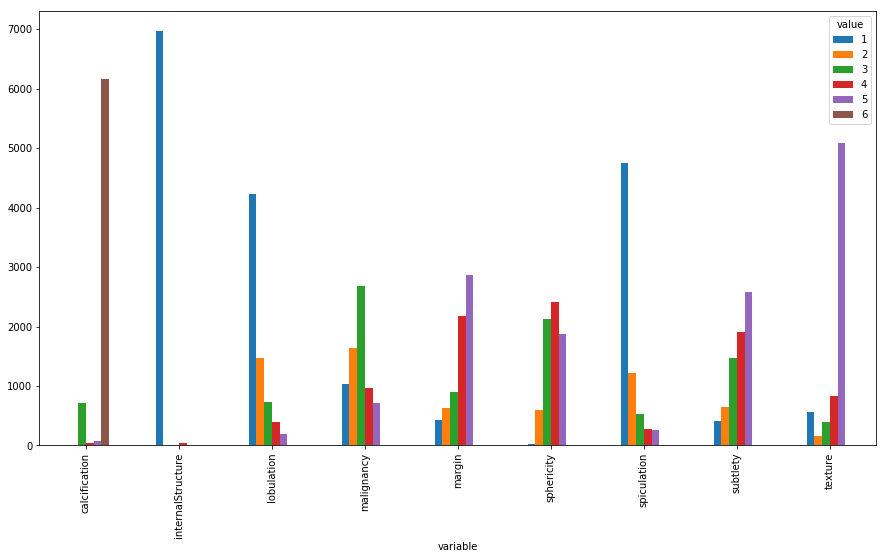

In [ ]:
pivot.plot.bar(figsize=(15,8))

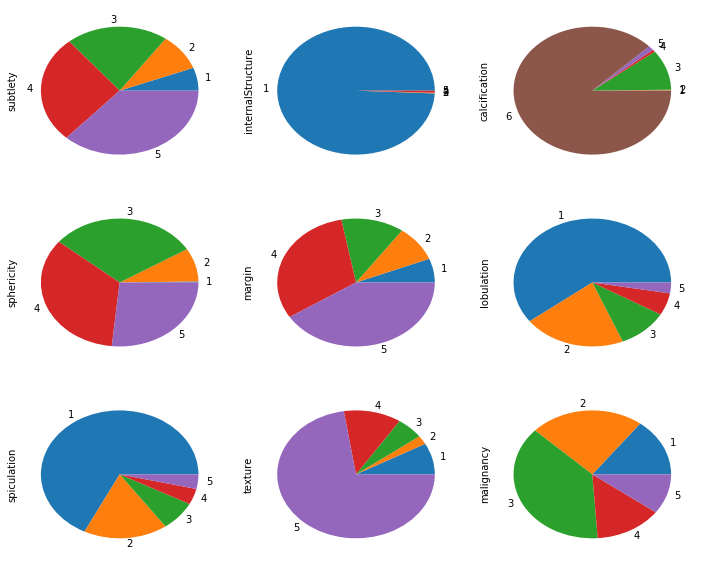

In [ ]:
plt.figure(figsize=(12,10))
for i, char in enumerate(characteristics_tags):
    plt.subplot(3, 3, i+1)
    pivot.loc[char].plot.pie();

In [ ]:
import seaborn as sns

In [ ]:
r =  np.random.rand(*characteristics_df.shape)
r = ((r - r.min())/(r.max() - r.min())) - 0.5
tt = characteristics_df + r

In [ ]:
import warnings
warnings.filterwarnings('ignore')

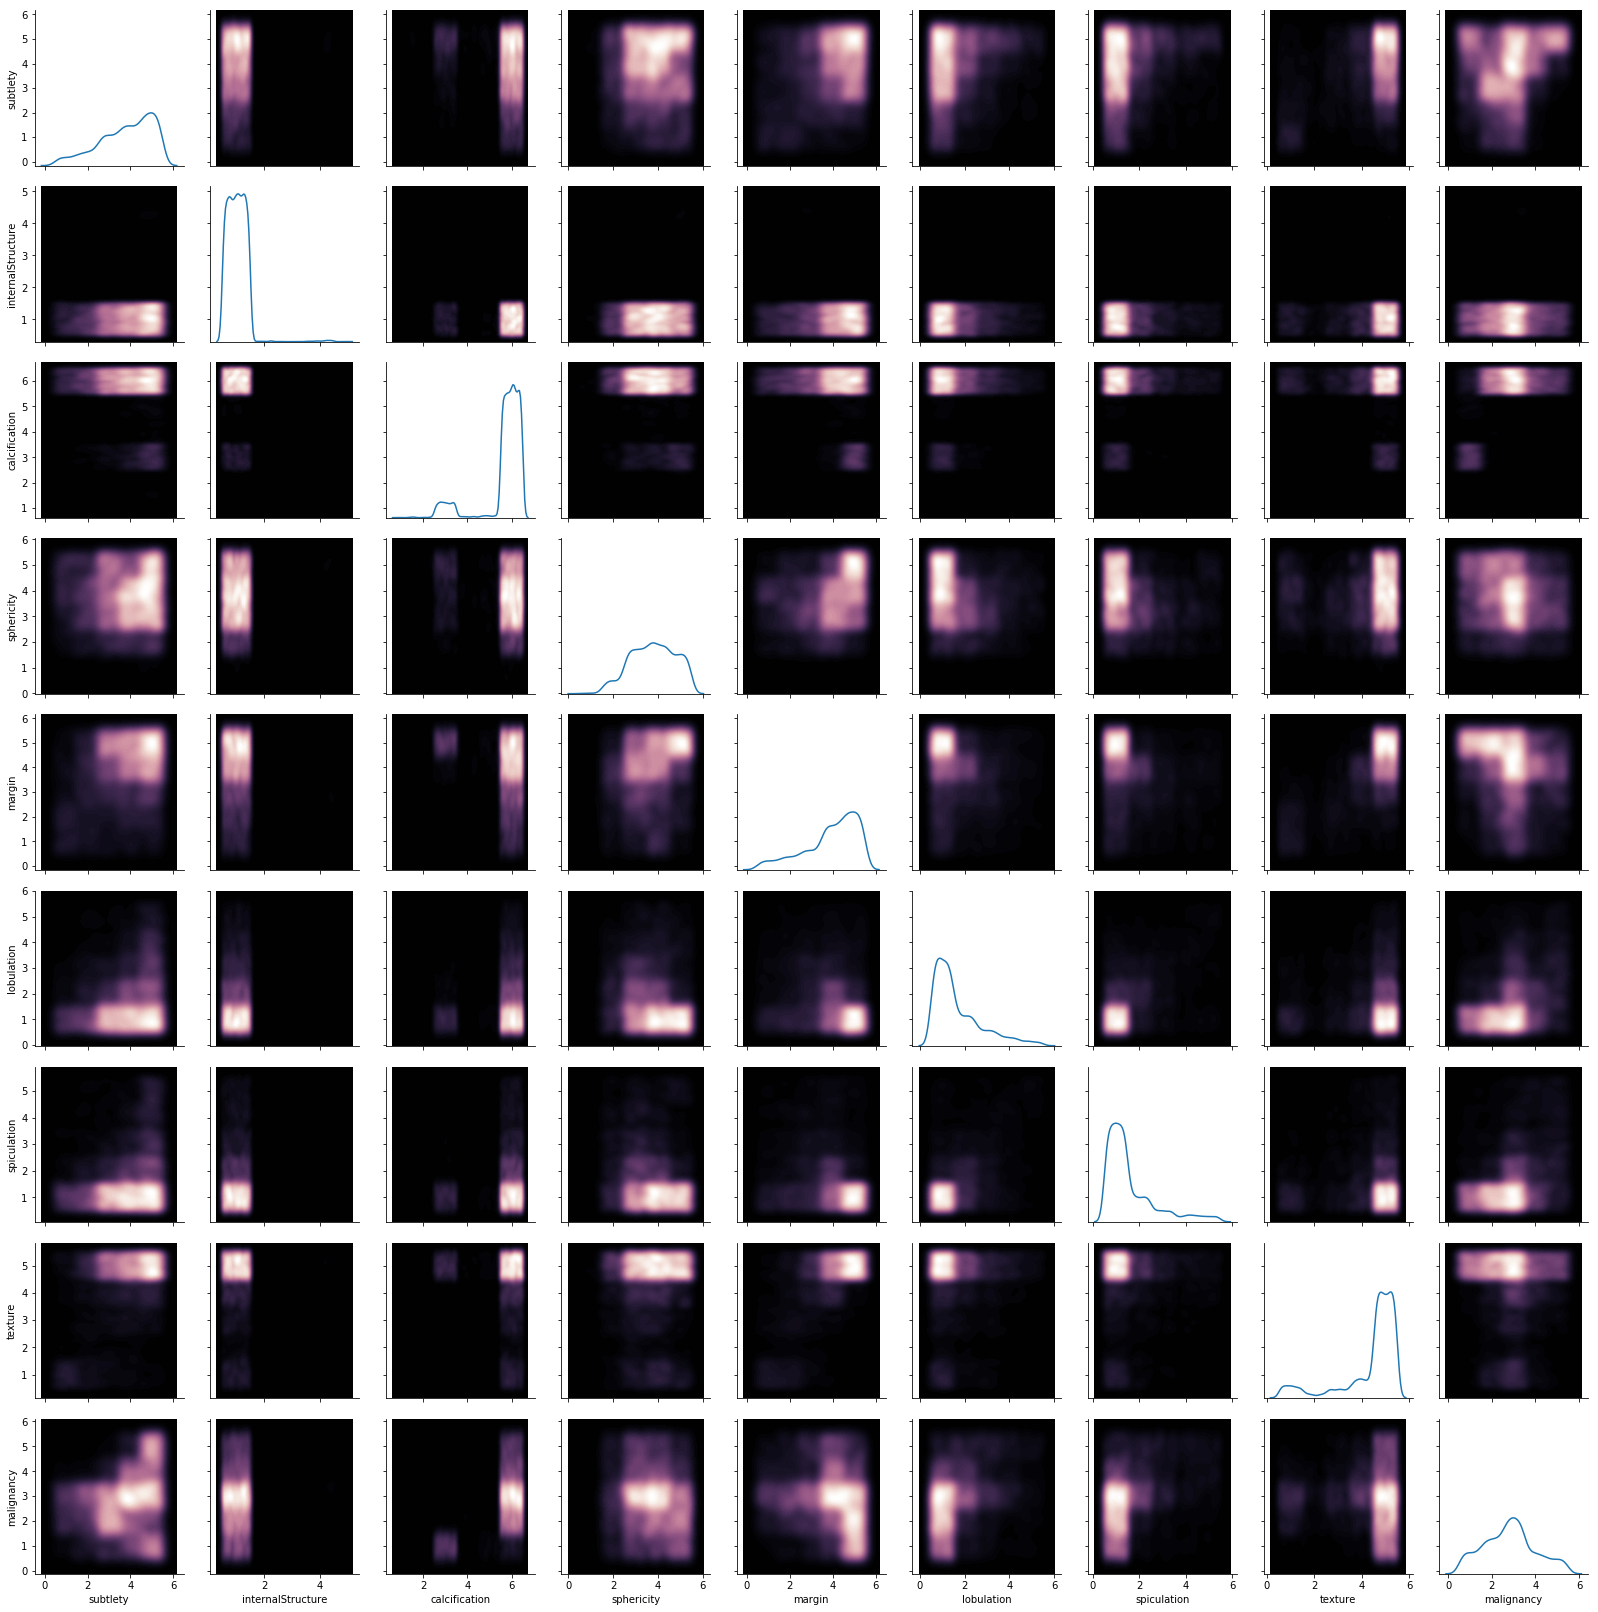

In [ ]:
g = sns.PairGrid(tt)
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
g = g.map_offdiag(sns.kdeplot, cmap=cmap, n_levels=90, shade=True)
g.map_diag(sns.kdeplot)